In [1]:
# Step 1: Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow as tf


In [5]:
# Step 2: Load dataset
df = pd.read_csv(r"C:\Users\Devra\Wind_energy_prediction\Results\processed_hourly.csv", index_col='Date/Time', parse_dates=True)


# Display first few rows
df.head()


,ActivePower_kW,WindSpeed_mps,TheoreticalPowerCurve_kWh,WindDirection_deg
Date/Time,,,,
2018-01-01 00:00:00,390.480362,5.506868,472.402227,267.118632
2018-01-01 01:00:00,460.537125,5.644205,513.418408,258.945546
2018-01-01 02:00:00,733.655375,6.452037,788.401310,268.397466
2018-01-01 03:00:00,909.362081,6.811455,948.793346,256.014765
2018-01-01 04:00:00,1393.518188,7.748749,1406.391795,247.652468


In [6]:
# Step 3: Select features and target
features = df[['WindSpeed_mps']]
target = df['ActivePower_kW']

# Normalize the features using MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(features)
y_scaled = scaler_y.fit_transform(target.values.reshape(-1,1))


In [7]:
# Step 4: Create time series sequences
def create_sequences(X, y, time_steps=24):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i+time_steps)])
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 24
X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_steps)

print("X_seq shape:", X_seq.shape)
print("y_seq shape:", y_seq.shape)


X_seq shape: (8736, 24, 1)
y_seq shape: (8736, 1)


In [8]:
# Step 5: Train-test split (80-20)
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])


Training samples: 6988
Testing samples: 1748


In [9]:
# Step 6: Define LSTM Model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()


c:\Users\Devra\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Step 7: Train model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)


Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0592 - val_loss: 0.0488
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0434 - val_loss: 0.0418
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0392 - val_loss: 0.0381
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0373 - val_loss: 0.0364
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0356 - val_loss: 0.0357
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0338 - val_loss: 0.0346
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0328 - val_loss: 0.0333
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0322 - val_loss: 0.0328
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0315 - val_loss: 0.0320
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0308 - val_loss: 0.0312
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0296 - val_loss: 0.0301
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 

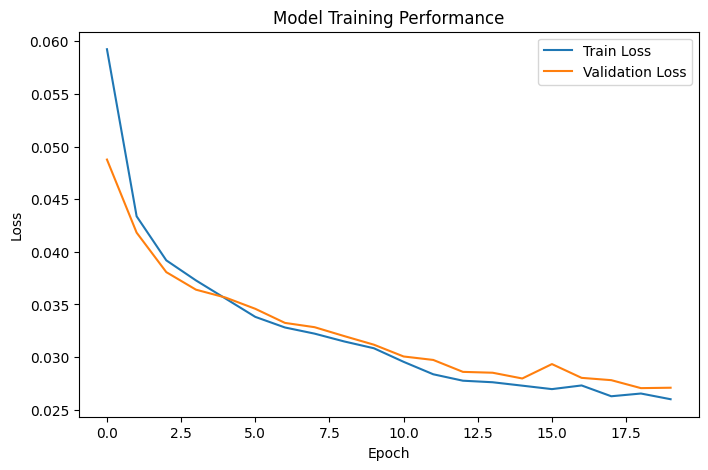

In [11]:
# Step 8: Plot training & validation loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training Performance')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [12]:
# Step 9: Model Evaluation
y_pred = model.predict(X_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)
y_test_inv = scaler_y.inverse_transform(y_test)

# Calculate error metrics
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.4f}")


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
RMSE: 593.32
MAE: 419.40
R² Score: 0.8006


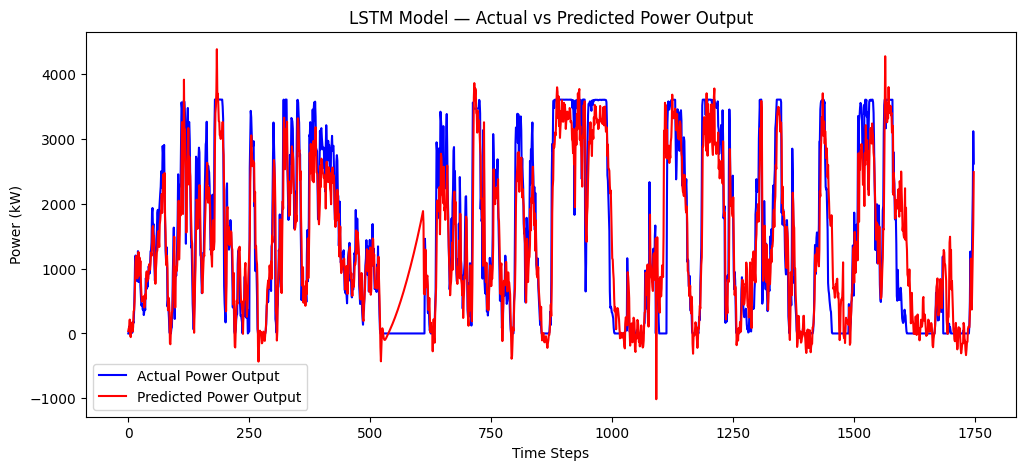

In [13]:
# Step 10: Forecast Visualization
plt.figure(figsize=(12,5))
plt.plot(y_test_inv, label='Actual Power Output', color='blue')
plt.plot(y_pred_inv, label='Predicted Power Output', color='red')
plt.title('LSTM Model — Actual vs Predicted Power Output')
plt.xlabel('Time Steps')
plt.ylabel('Power (kW)')
plt.legend()
plt.show()


In [14]:
# Step 11: Save Model and Scalers
model.save("C:/Users/Devra/Wind_energy_prediction/Models/lstm_model.h5")

import joblib
joblib.dump(scaler_X, "C:/Users/Devra/Wind_energy_prediction/Models/scaler_X.pkl")
joblib.dump(scaler_y, "C:/Users/Devra/Wind_energy_prediction/Models/scaler_y.pkl")

print("✅ Model and scalers saved successfully!")


✅ Model and scalers saved successfully!


In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import os


In [6]:
# Load your cleaned data
df = pd.read_csv(r"C:\Users\Devra\Wind_energy_prediction\Results\processed_hourly.csv", parse_dates=True, index_col='Date/Time')

# Select features and target
data = df[['WindSpeed_mps', 'ActivePower_kW']].copy()
data.dropna(inplace=True)

print(data.head())


                     WindSpeed_mps  ActivePower_kW
Date/Time                                         
2018-01-01 00:00:00       5.506868      390.480362
2018-01-01 01:00:00       5.644205      460.537125
2018-01-01 02:00:00       6.452037      733.655375
2018-01-01 03:00:00       6.811455      909.362081
2018-01-01 04:00:00       7.748749     1393.518188


In [7]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Convert to dataframe for convenience
scaled_df = pd.DataFrame(scaled_data, columns=['WindSpeed_mps', 'ActivePower_kW'], index=data.index)


In [8]:
def create_sequences(dataset, look_back=24):
    X, y = [], []
    for i in range(look_back, len(dataset)):
        X.append(dataset[i-look_back:i, 0])  # Wind speed (feature)
        y.append(dataset[i, 1])              # Power output (target)
    return np.array(X), np.array(y)

look_back = 24  # past 24 hours
X, y = create_sequences(scaled_data, look_back)

# Reshape for LSTM: [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [10]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


c:\Users\Devra\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0607 - val_loss: 0.0471
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0397 - val_loss: 0.0385
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0319 - val_loss: 0.0324
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0287 - val_loss: 0.0308
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0268 - val_loss: 0.0296
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0254 - val_loss: 0.0290
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0253 - val_loss: 0.0275
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0249 - val_loss: 0.0278
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0243 - val_loss: 0.0271
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0243 - val_loss: 0.0269
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0240 - val_loss: 0.0278
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 

In [11]:
os.makedirs("C:/Users/Devra/Wind_energy_prediction/models", exist_ok=True)
model.save("C:/Users/Devra/Wind_energy_prediction/models/lstm_model.h5")

print("✅ LSTM model saved successfully at:")
print("C:/Users/Devra/Wind_energy_prediction/models/lstm_model.h5")


✅ LSTM model saved successfully at:
C:/Users/Devra/Wind_energy_prediction/models/lstm_model.h5
